# Visual Contrast Analysis


## Part 1: Trying to compare the brightness

### 1. Download and import

In terminal: (all these commands are for windows)
Creating your new environment: python -m venv sam-env (my env is called sam-env, change it if you like)
, Open the environment: sam-env\Scripts\activate




Use requirements.txt / but you're using mac so you need to find the mac version of the following downloads.


pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118 

    

pip install opencv-python matplotlib numpy

pip install numpy opencv-python matplotlib torch torchvision git+https://github.com/facebookresearch/segment-anything.git

In this link download sam_vit_b_01ec64.pth and manually put it into the same folder of your notebook file: 
https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth

pip install scikit-image

In [129]:
%matplotlib inline
#you might not need to run this, I ran this because my notebook isn't showing any images.


In [130]:
import skimage
from skimage import color


In [131]:
print(skimage.__version__)

0.25.2


In [132]:
import numpy as np
print(np.__version__)


2.2.5


In [133]:
import matplotlib.pyplot as plt
import cv2
import torch
from PIL import Image
from segment_anything import sam_model_registry, SamPredictor


In [134]:
# you need to change this line because you're using mac, but i don't know how to
device = "cuda" if torch.cuda.is_available() else "cpu"

# check sam_vit_b_01ec64.pth and notebook are in the same folder）
sam_checkpoint = "sam_vit_b_01ec64.pth"
model_type = "vit_b"

In [135]:
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device)

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d()
    )


In [136]:
#prepare for cuting image
predictor = SamPredictor(sam)

print("Segment Anything ready")

Segment Anything ready


### Preparing the image

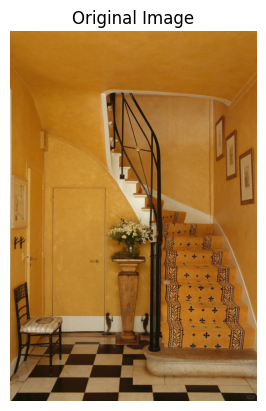

In [137]:
image_path = "D:\cci 2025\segmentation\chair (2).jpg"

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image)
plt.axis('off')
plt.title("Original Image")
plt.show()

predictor.set_image(image)

We need to set a point on the chair in the image to regonise and seperate from the background. We can automatically set the point on the chair if we use YOLO to recognise the chair first. But in this demo i just set the point(x,y) by hand.

In [138]:
#get the pixel of the image for finding where should i put the point
h, w, _ = image.shape
input_point = np.array([[w // 2, h // 2]])
input_label = np.array([1])  

print("image =", h, w)
print("image center = ", input_point)


image = 1620 1080
image center =  [[540 810]]


### Segmentation

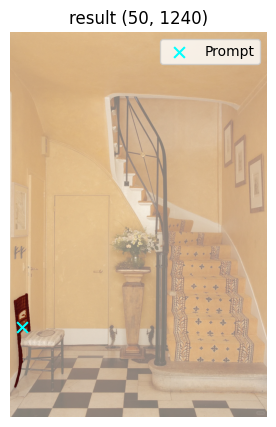

In [139]:
#set the point by changing x and y
x, y = 50, 1240 

input_point = np.array([[x, y]])
input_label = np.array([1])  # foreground

#use sam for segmentation
masks, _, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=False
)

mask = masks[0]

#use plt to visualise
plt.figure(figsize=(10, 5))
plt.imshow(image)
plt.imshow(mask, alpha=0.5, cmap='Reds')
plt.scatter([x], [y], color='cyan', s=60, marker='x', label='Prompt')
plt.title(f"result ({x}, {y})")
plt.legend()
plt.axis('off')
plt.show()


### Compare and print the brightness of the chair and the background

In [140]:
def compute_brightness(region):
    """
    region: shape (N, 3), RGB pixel array
    return: average perceived brightness
    """
    r, g, b = region[:, 0], region[:, 1], region[:, 2]
    return np.mean(0.2126 * r + 0.7152 * g + 0.0722 * b)

# 1. Extract chair pixels from the mask (mask == True)
mask_bool = mask.astype(bool)
chair_pixels = image[mask_bool]

# 2. Extract background pixels (mask == False)
background_pixels = image[~mask_bool]

# 3. Compute average brightness
chair_brightness = compute_brightness(chair_pixels)
background_brightness = compute_brightness(background_pixels)

# 4. Compute brightness contrast
contrast = abs(chair_brightness - background_brightness)

# 5. Print result
print(f"Chair brightness: {chair_brightness:.2f}")
print(f"Background brightness: {background_brightness:.2f}")
print(f"Brightness contrast: {contrast:.2f}")

# 6. Threshold for visual distinction
contrast_threshold = 20
if contrast > contrast_threshold:
    print("The chair stands out clearly from the background.")
else:
    print("The chair blends into the background.")



Chair brightness: 44.15
Background brightness: 113.70
Brightness contrast: 69.55
The chair stands out clearly from the background.


## Trying to compare the colour

Comparing brightness only is not that accurate, adding colour to make the result more accurate

### Define the functions

In [141]:
def compute_brightness(region):
    """
    Compute average brightness using the luminance formula.
    region: shape (N, 3), RGB pixels
    """
    r, g, b = region[:, 0], region[:, 1], region[:, 2]
    return np.mean(0.2126 * r + 0.7152 * g + 0.0722 * b)


In [142]:
def analyze_visual_contrast(image, mask, brightness_threshold=40, delta_e_threshold=20, verbose=True):
    """
    Analyze visual contrast between foreground (mask) and background.

    Parameters:
        image: RGB image
        mask: boolean array (True for chair)
        brightness_threshold: threshold for brightness contrast
        delta_e_threshold: threshold for color contrast
        verbose: whether to print results

    Returns:
        Dictionary of analysis results
    """
    mask_bool = mask.astype(bool)
    chair_pixels = image[mask_bool]
    background_pixels = image[~mask_bool]

    # Brightness analysis
    chair_brightness = compute_brightness(chair_pixels)
    bg_brightness = compute_brightness(background_pixels)
    brightness_contrast = abs(chair_brightness - bg_brightness)

    if brightness_contrast > brightness_threshold:
        brightness_result = "Chair is visually distinct in brightness."
    else:
        brightness_result = "Chair may blend in brightness."

    # Color contrast using ΔE in Lab space
    chair_lab = color.rgb2lab(chair_pixels.reshape(-1, 1, 3) / 255.0)
    bg_lab = color.rgb2lab(background_pixels.reshape(-1, 1, 3) / 255.0)

    chair_avg_lab = np.mean(chair_lab, axis=0)
    bg_avg_lab = np.mean(bg_lab, axis=0)
    delta_e = np.linalg.norm(chair_avg_lab - bg_avg_lab)

    if delta_e > delta_e_threshold:
        color_result = "Chair is visually distinct in color."
    else:
        color_result = "Chair may blend in color."

    if verbose:
        print(f"Chair brightness: {chair_brightness:.2f}")
        print(f"Background brightness: {bg_brightness:.2f}")
        print(f"Brightness contrast: {brightness_contrast:.2f}")
        print(f"Result: {brightness_result}")
        print()
        print(f"Color contrast (ΔE): {delta_e:.2f}")
        print(f"Result: {color_result}")

    return {
        "chair_brightness": chair_brightness,
        "background_brightness": bg_brightness,
        "brightness_contrast": brightness_contrast,
        "delta_e": delta_e,
        "brightness_result": brightness_result,
        "color_result": color_result
    }


### Printing result

In [143]:
results = analyze_visual_contrast(image, mask)


Chair brightness: 44.15
Background brightness: 113.70
Brightness contrast: 69.55
Result: Chair is visually distinct in brightness.

Color contrast (ΔE): 38.68
Result: Chair is visually distinct in color.


### Visualising the result

In [144]:
import matplotlib.pyplot as plt

def visualize_contrast_result(image, mask, result_dict, point=None):
    """
    Overlay brightness and color analysis result on the original image.
    
    Parameters:
        image: original RGB image
        mask: boolean mask array
        result_dict: output from analyze_visual_contrast
        point: (optional) [x, y] of the prompt point (for marker)
    """
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.imshow(image)
    ax.imshow(mask, alpha=0.4, cmap='Reds')

    #mark the prompt point
    if point is not None:
        ax.scatter([point[0]], [point[1]], color='cyan', s=60, marker='x', label='Prompt')

    # Format result text
    lines = [
        f"Brightness Contrast: {result_dict['brightness_contrast']:.2f}",
        result_dict['brightness_result'],
        f"Color Contrast (ΔE): {result_dict['delta_e']:.2f}",
        result_dict['color_result']
    ]

    # Display text in top-left corner
    # change (10, 100 + i * 90) to change the position, and space between lines
    img_h, img_w, _ = image.shape
    base_y = int(0.05 * img_h)
    line_spacing = int(0.05 * img_h)

    for i, line in enumerate(lines):
        ax.text(10, base_y + i * line_spacing, line,
            color='white', fontsize=10, backgroundcolor='black')


    ax.set_title("Visual Contrast Analysis", fontsize=14)
    ax.axis('off')
    plt.show()


After setting the function in the previous cell, run this line to get the image.

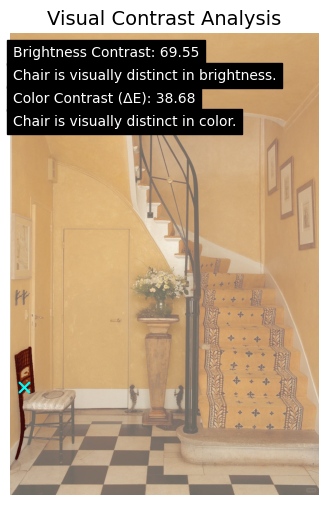

In [145]:
visualize_contrast_result(image, mask, results, point=[x, y])


### Make the visualisation better

Put the original image on the right, and create an outcome folder for saving the result image, filename = "result_orignial file name"

In [146]:
import os
import matplotlib.pyplot as plt

def visualize_contrast_result(image, mask, result_dict, point=None, filename=None, save_dir='outcome'):
    """
    Display visual contrast analysis next to the original image, and save the result.
    
    Parameters:
        image: Original RGB image
        mask: Boolean mask (True = chair region)
        result_dict: Output from analyze_visual_contrast(...)
        point: Optional [x, y] coordinate for prompt point
        filename: Original image filename (e.g. "chair.jpg")
        save_dir: Directory to save the result image
    """
    # Create side-by-side figure
    fig, axs = plt.subplots(1, 2, figsize=(16, 6))
    plt.subplots_adjust(wspace=0) 

    # Left: Analysis with mask and text
    axs[0].imshow(image)
    axs[0].imshow(mask, alpha=0.4, cmap='Reds')
    if point is not None:
        axs[0].scatter([point[0]], [point[1]], color='cyan', s=60, marker='x', label='Prompt')
    axs[0].set_title("Visual Contrast Analysis", fontsize=14)
    axs[0].axis('off')

    # Add result text
    lines = [
        f"Brightness Contrast: {result_dict['brightness_contrast']:.2f}",
        result_dict['brightness_result'],
        f"Color Contrast (ΔE): {result_dict['delta_e']:.2f}",
        result_dict['color_result']
    ]

    img_h, img_w, _ = image.shape
    base_y = int(0.05 * img_h)
    line_spacing = int(0.05 * img_h)

    for i, line in enumerate(lines):
        axs[0].text(10, base_y + i * line_spacing, line,
                color='white', fontsize=10, backgroundcolor='black')


    # Right: Original image (unchanged)
    axs[1].imshow(image)
    axs[1].set_title("Original Image", fontsize=14)
    axs[1].axis('off')



    # Save figure
    if filename:
        os.makedirs(save_dir, exist_ok=True)
        base = os.path.basename(filename)
        name, _ = os.path.splitext(base)
        save_path = os.path.join(save_dir, f"result_{name}.png")
        plt.savefig(save_path, dpi=150)
        print(f"Result image saved to: {save_path}")


    plt.show()


After setting the function in the previous cell, run this line to get the image.

Result image saved to: outcome\result_chair (2).png


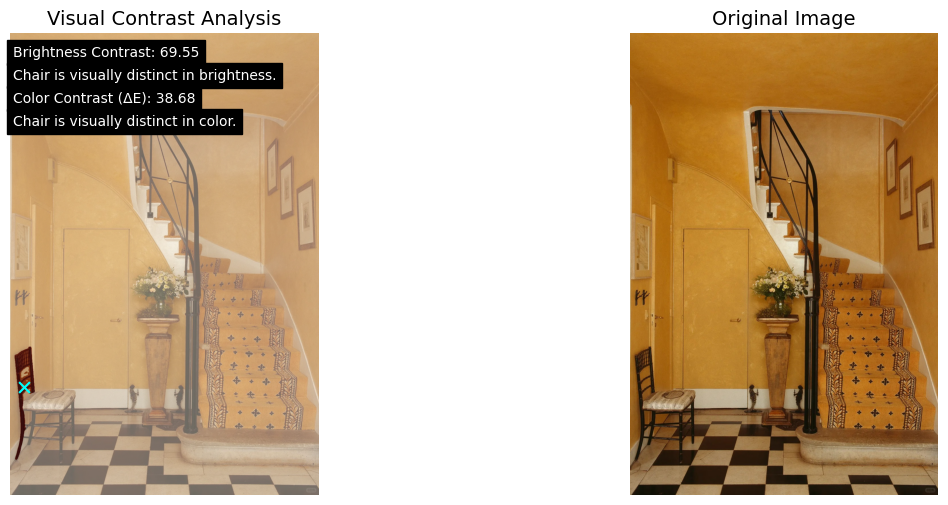

In [147]:
visualize_contrast_result(image, mask, results, point=[x, y], filename="chair (2).jpg")


## Analyse a new image

If want to analyse new images, recommand copy these cells for each images instead of changing the original code

### New image

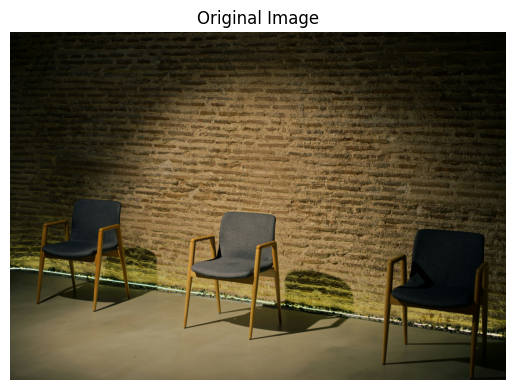

In [148]:
image_path = "D:\cci 2025\segmentation\chair (1).jpg"

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image)
plt.axis('off')
plt.title("Original Image")
plt.show()

predictor.set_image(image)


### Choosing new point manually

In [149]:
h, w, _ = image.shape
input_point = np.array([[w // 2, h // 2]])
input_label = np.array([1]) 

print("image =", h, w)
print("image center = ", input_point)

image = 5178 7371
image center =  [[3685 2589]]


In [ ]:
x, y = 3600, 2900  #Choose a new point for this image
input_point = np.array([[x, y]])
input_label = np.array([1])

masks, _, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=False
)

mask = masks[0]

#to see the point you chose
plt.figure(figsize=(10, 5))
plt.imshow(image)
plt.imshow(mask, alpha=0.5, cmap='Reds')
plt.scatter([x], [y], color='cyan', s=60, marker='x', label='Prompt')
plt.title(f"result ({x}, {y})")
plt.legend()
plt.axis('off')
plt.show()

### Analyse the image

Chair brightness: 89.77
Background brightness: 69.46
Brightness contrast: 20.31
Result: Chair may blend in brightness.

Color contrast (ΔE): 14.51
Result: Chair may blend in color.
Result image saved to: outcome\result_chair (1).png


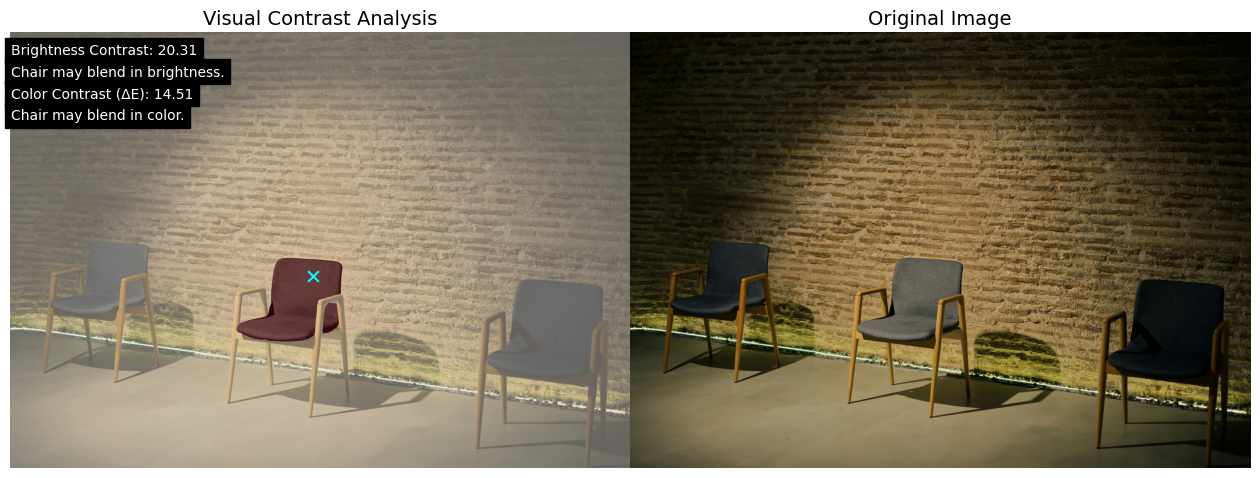

In [151]:
results = analyze_visual_contrast(image, mask)
visualize_contrast_result(image, mask, results, point=[x, y], filename=image_path)


### Another new image

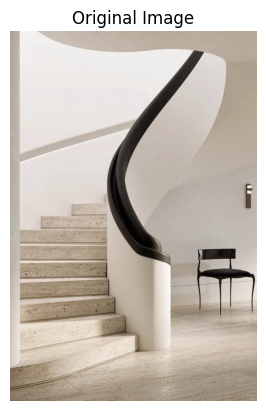

In [ ]:
image_path = "D:\cci 2025\segmentation\chair (3).jpg"

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image)
plt.axis('off')
plt.title("Original Image")
plt.show()

predictor.set_image(image)


In [153]:
h, w, _ = image.shape
input_point = np.array([[w // 2, h // 2]])
input_label = np.array([1]) 

print("image =", h, w)
print("image center = ", input_point)

image = 1200 800
image center =  [[400 600]]


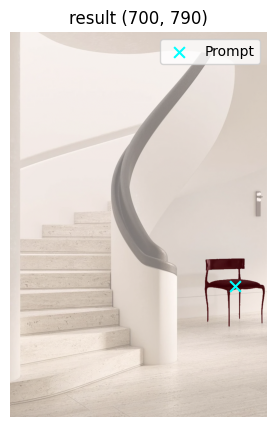

In [159]:
x, y = 700, 790  #Choose a new point for this image
input_point = np.array([[x, y]])
input_label = np.array([1])

masks, _, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=False
)

mask = masks[0]

#to see the point you chose
plt.figure(figsize=(10, 5))
plt.imshow(image)
plt.imshow(mask, alpha=0.5, cmap='Reds')
plt.scatter([x], [y], color='cyan', s=60, marker='x', label='Prompt')
plt.title(f"result ({x}, {y})")
plt.legend()
plt.axis('off')
plt.show()


Chair brightness: 37.43
Background brightness: 182.56
Brightness contrast: 145.13
Result: Chair is visually distinct in brightness.

Color contrast (ΔE): 59.37
Result: Chair is visually distinct in color.
Result image saved to: outcome\result_chair (3).png


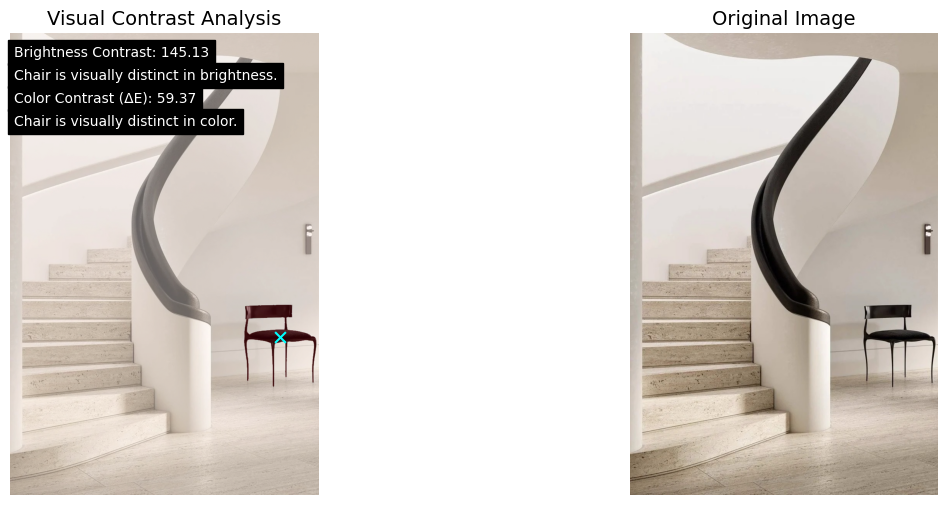

In [160]:
results = analyze_visual_contrast(image, mask)
visualize_contrast_result(image, mask, results, point=[x, y], filename=image_path)
